In [1]:
import itertools

import pandas as pd
import numpy as np

from sklearn.feature_selection import mutual_info_regression as MI
from scipy import stats as st

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 1. Orthogonal mixture

In [57]:
def orthogonal_mixture_source_separation(
    N,
    K,
    source_pdf_fn,
    mixing_theta=None
):

    # Generate sources
    a=source_pdf_fn(
        s=(K,N)
    )

    # Mixing matrix
    if mixing_theta is None:
        mixing_theta = np.pi*np.random.uniform(0,1)
    print('-'*100)
    print('Mixing theta: {}*pi'.format(mixing_theta/np.pi))
    print('-'*100)
    H = np.array([
        [np.cos(mixing_theta), -np.sin(mixing_theta)],
        [np.sin(mixing_theta), np.cos(mixing_theta)]
    ])

    # Get mixed signals
    x = H@a

    # Plot signals
    fig, (ax1, ax2) = plt.subplots(
        nrows=2, ncols=1,
        figsize=(20, 15)
    )
    fig.suptitle(
        'Time-domain signal plots',
        fontsize=20
    )
    for i in range(1,K+1):
        ax1.plot(
            range(N),
            a[i-1,:],
            label='a_{}'.format(i)
        )
        ax2.plot(
            range(N),
            x[i-1,:],
            label='x_{}'.format(i)
        )

    ax1.set_xlabel('n', fontsize=15)
    ax2.set_xlabel('n', fontsize=15)

    ax1.set_ylabel('a[n]', fontsize=15)
    ax2.set_ylabel('x[n]', fontsize=15)

    ax1.set_title('Independent sources', fontsize=15)
    ax2.set_title('Mixed signals', fontsize=15)

    ax1.legend(loc='upper right', fontsize=15)
    ax2.legend(loc='upper right', fontsize=15)
    
    fig2, (ax_scatter1, ax_scatter2) = plt.subplots(
        nrows=2,ncols=1,
        figsize=(20,20)
    )
    fig2.suptitle(
        'Signal scatter plots',
        fontsize=20
    )
    ax_scatter1.scatter(
        a[0,:],
        a[1,:]
    )
    ax_scatter1.axis('equal')
    ax_scatter1.set_xlabel('$x_{0}$', fontsize=15)
    ax_scatter1.set_ylabel('$x_{1}$', fontsize=15)
    ax_scatter1.set_title('Original sources scatterplot', fontsize=15)
    ax_scatter2.scatter(
        x[0,:],
        x[1,:]
    )
    ax_scatter2.axis('equal')
    ax_scatter2.set_xlabel('$x_{0}$', fontsize=15)
    ax_scatter2.set_ylabel('$x_{1}$', fontsize=15)
    ax_scatter2.set_title('Mixed sources scatterplot', fontsize=15)
    
    # Evaluated thetas
    eval_thetas = np.linspace(
        -np.pi, 0,
        100
    )

    # Iterate to find optimal W
    logs=pd.DataFrame()
    for k, theta in enumerate(eval_thetas):
        W = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        y=W@x

        # Update logs matrix
        logs_update = pd.DataFrame(
            index=[0],
            data={
                'it': [k],
                'theta': [theta],
                'mutual_info': [MI(
                    y.T, y.T[:,0]
                )[1]]
            }
        )    
        logs = pd.concat(
            [
                logs,
                logs_update
            ],
            axis=0
        )
        
    # Plot mutual info
    fig = plt.figure(figsize=((20,7)))
    plt.plot(
        logs.theta/np.pi,
        logs.mutual_info
    )
    plt.title('mutual info', fontsize=15)
    plt.xlabel('theta', fontsize=15)
    plt.ylabel('$\hat{MI}$', fontsize=15)

### 1.1. Two Logistic pdf sources

----------------------------------------------------------------------------------------------------
Mixing theta: 0.25*pi
----------------------------------------------------------------------------------------------------


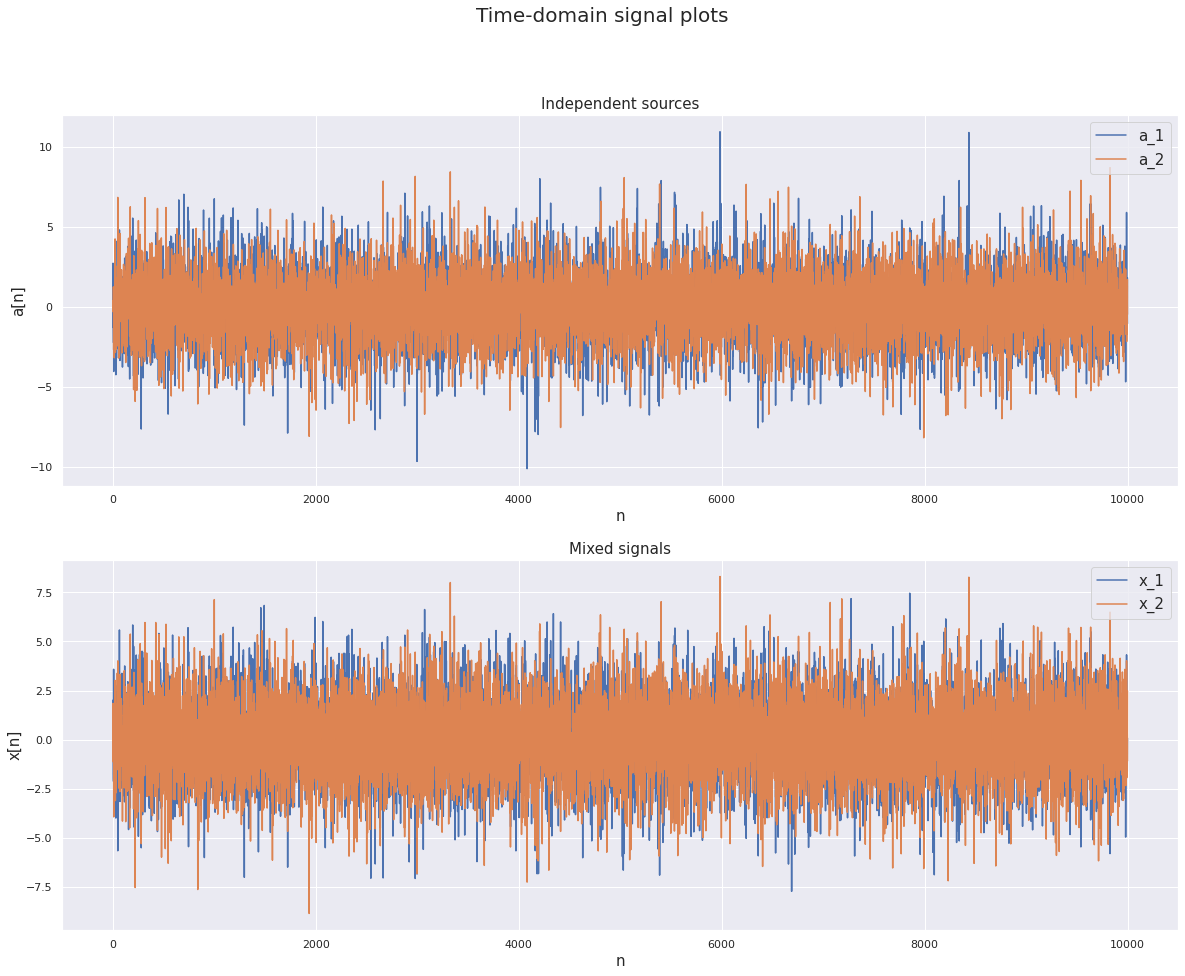

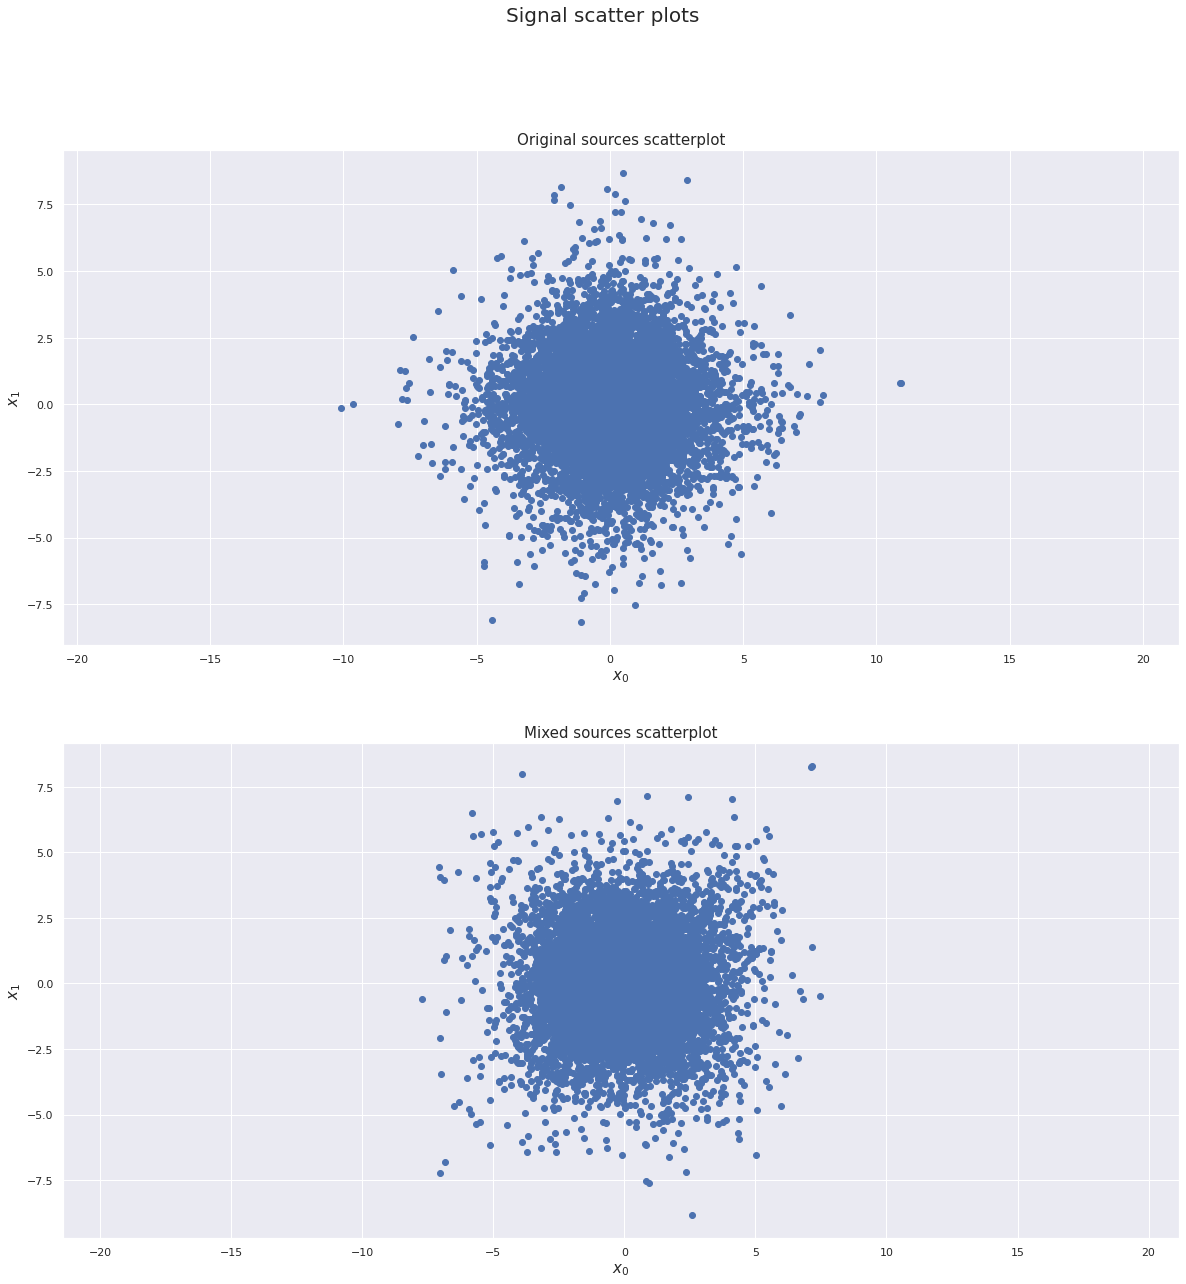

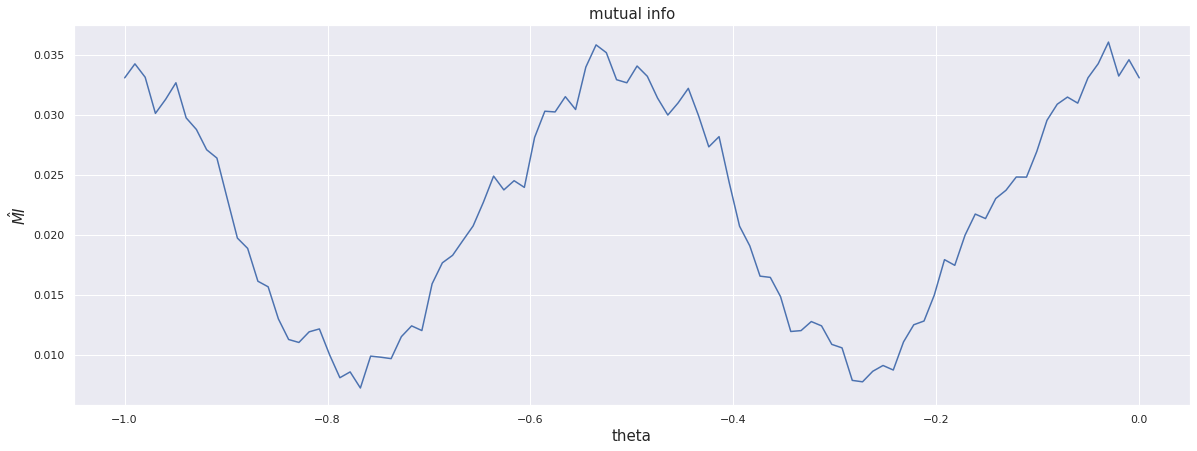

In [58]:
orthogonal_mixture_source_separation(
    N=10000,
    K=2,
    source_pdf_fn=lambda s: np.random.logistic(0,1,s),
    mixing_theta=np.pi/4
)

### 1.2. Two Uniform pdf sources

----------------------------------------------------------------------------------------------------
Mixing theta: 0.25*pi
----------------------------------------------------------------------------------------------------


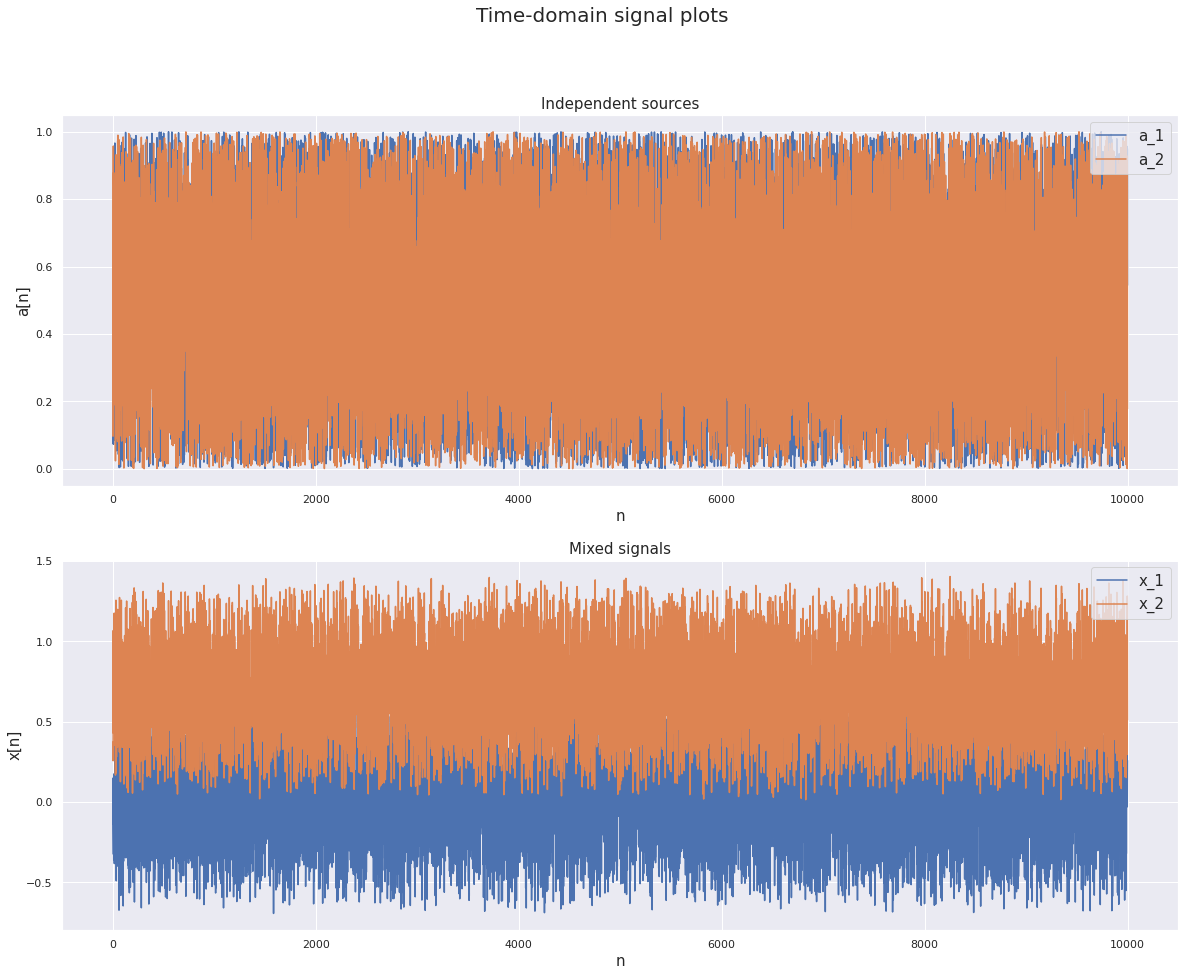

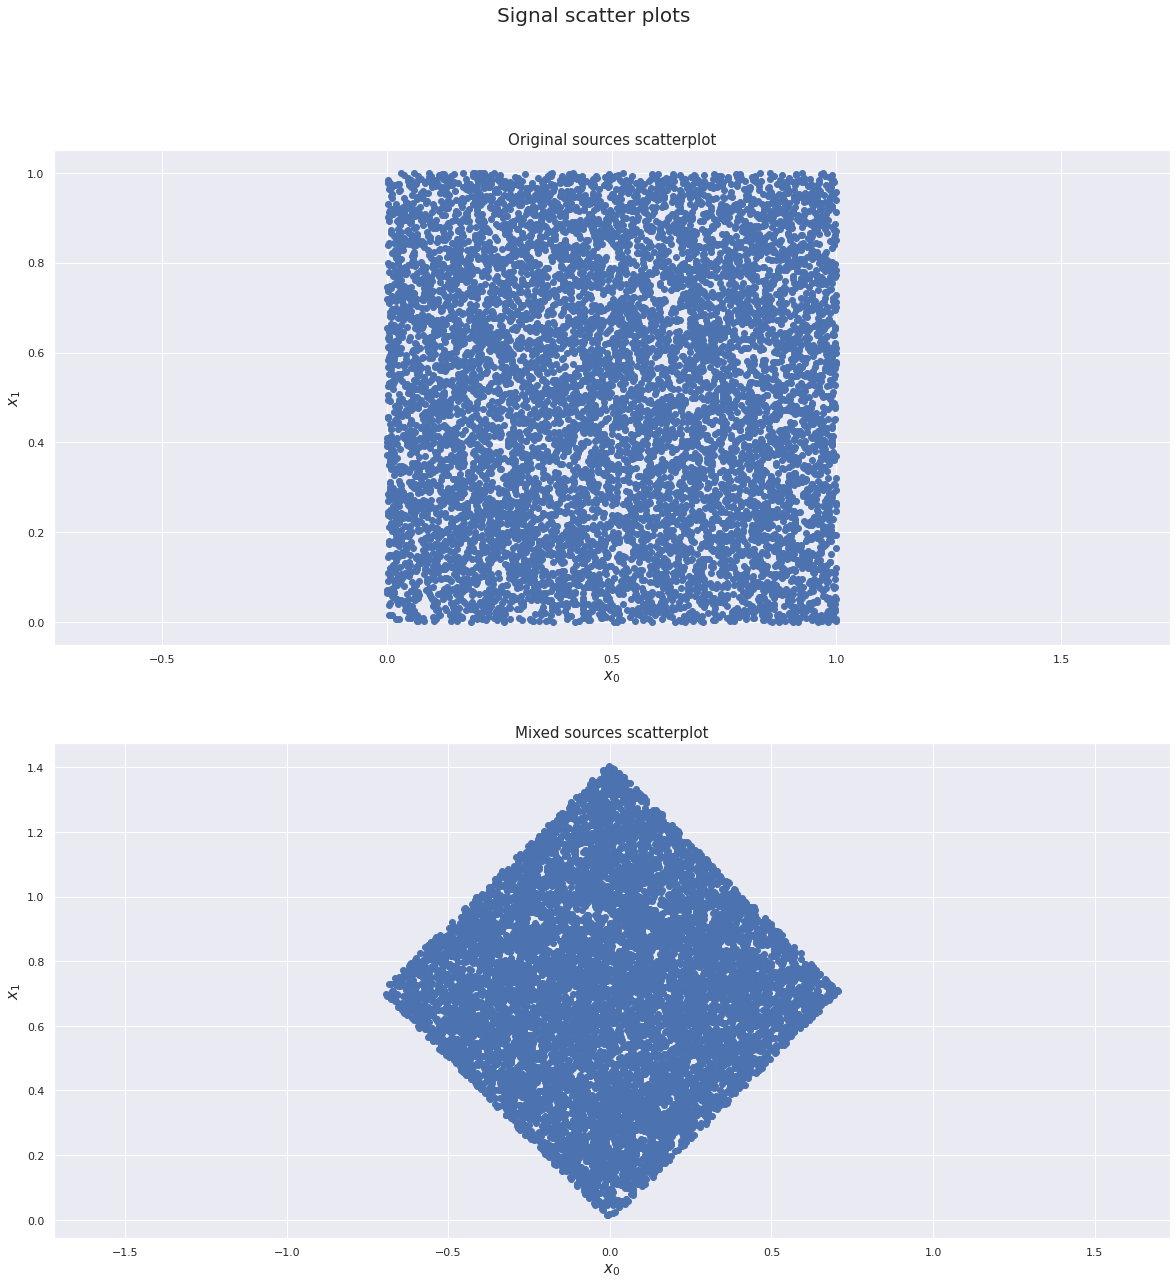

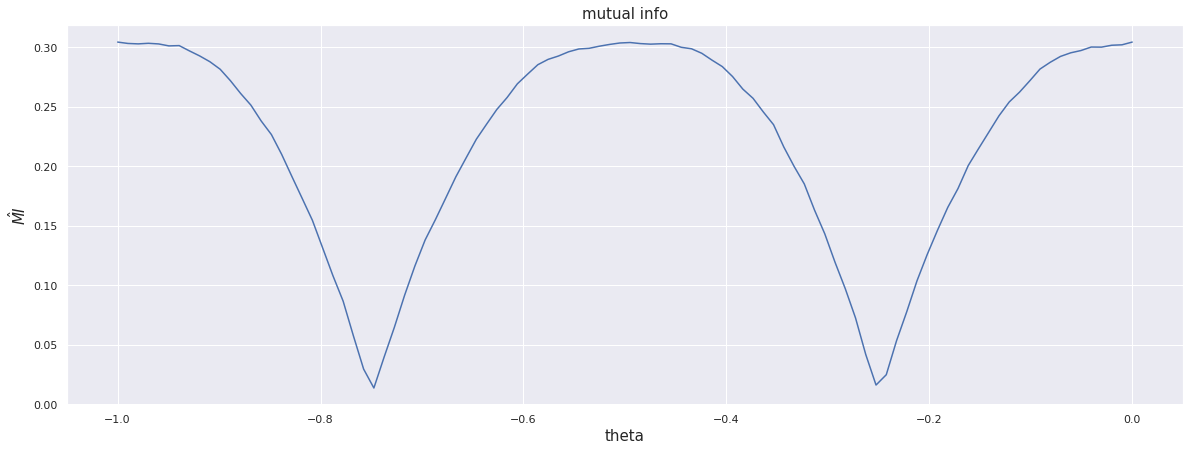

In [59]:
orthogonal_mixture_source_separation(
    N=10000,
    K=2,
    source_pdf_fn=lambda s: np.random.uniform(0,1,s),
    mixing_theta=np.pi/4
)

### 1.3. Two Gaussian pdf sources

----------------------------------------------------------------------------------------------------
Mixing theta: 0.25*pi
----------------------------------------------------------------------------------------------------


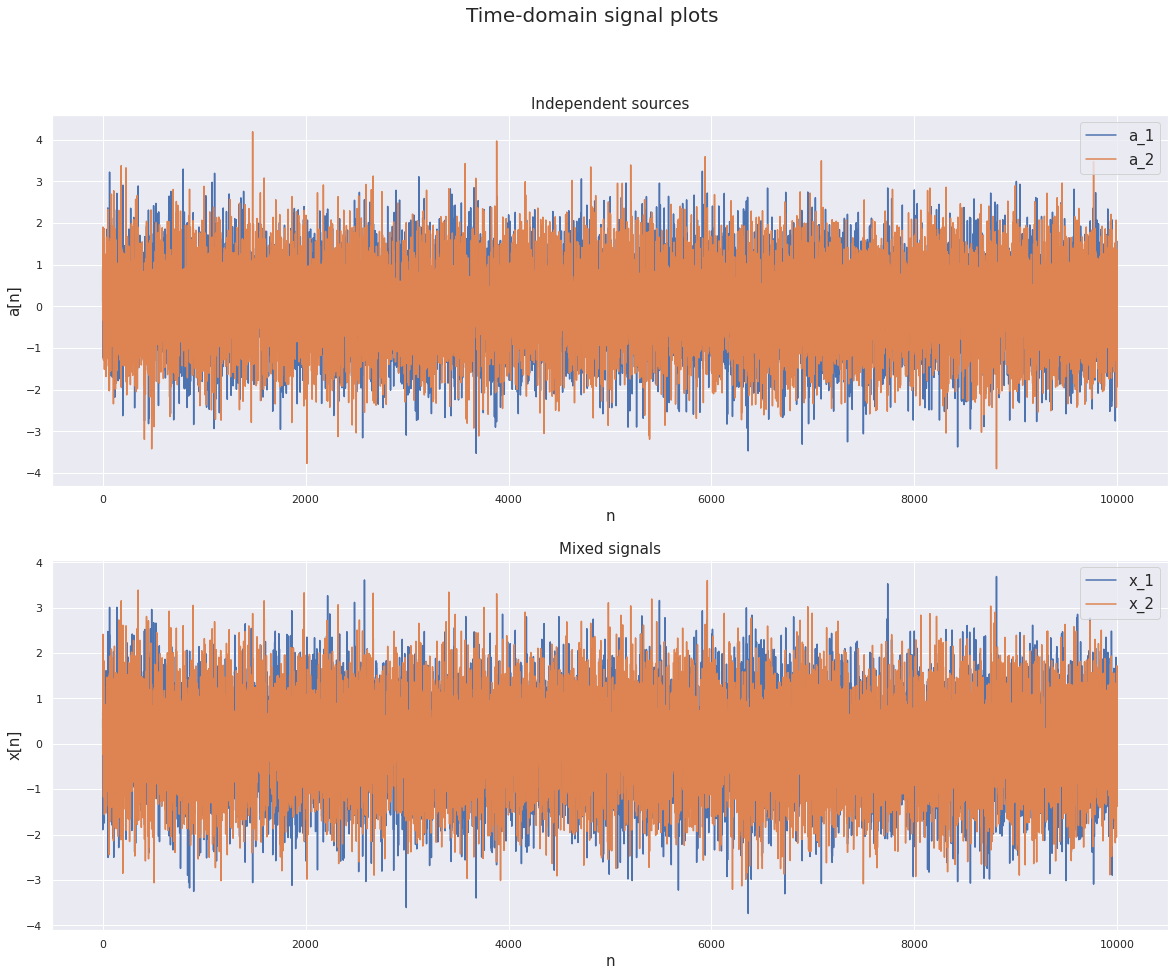

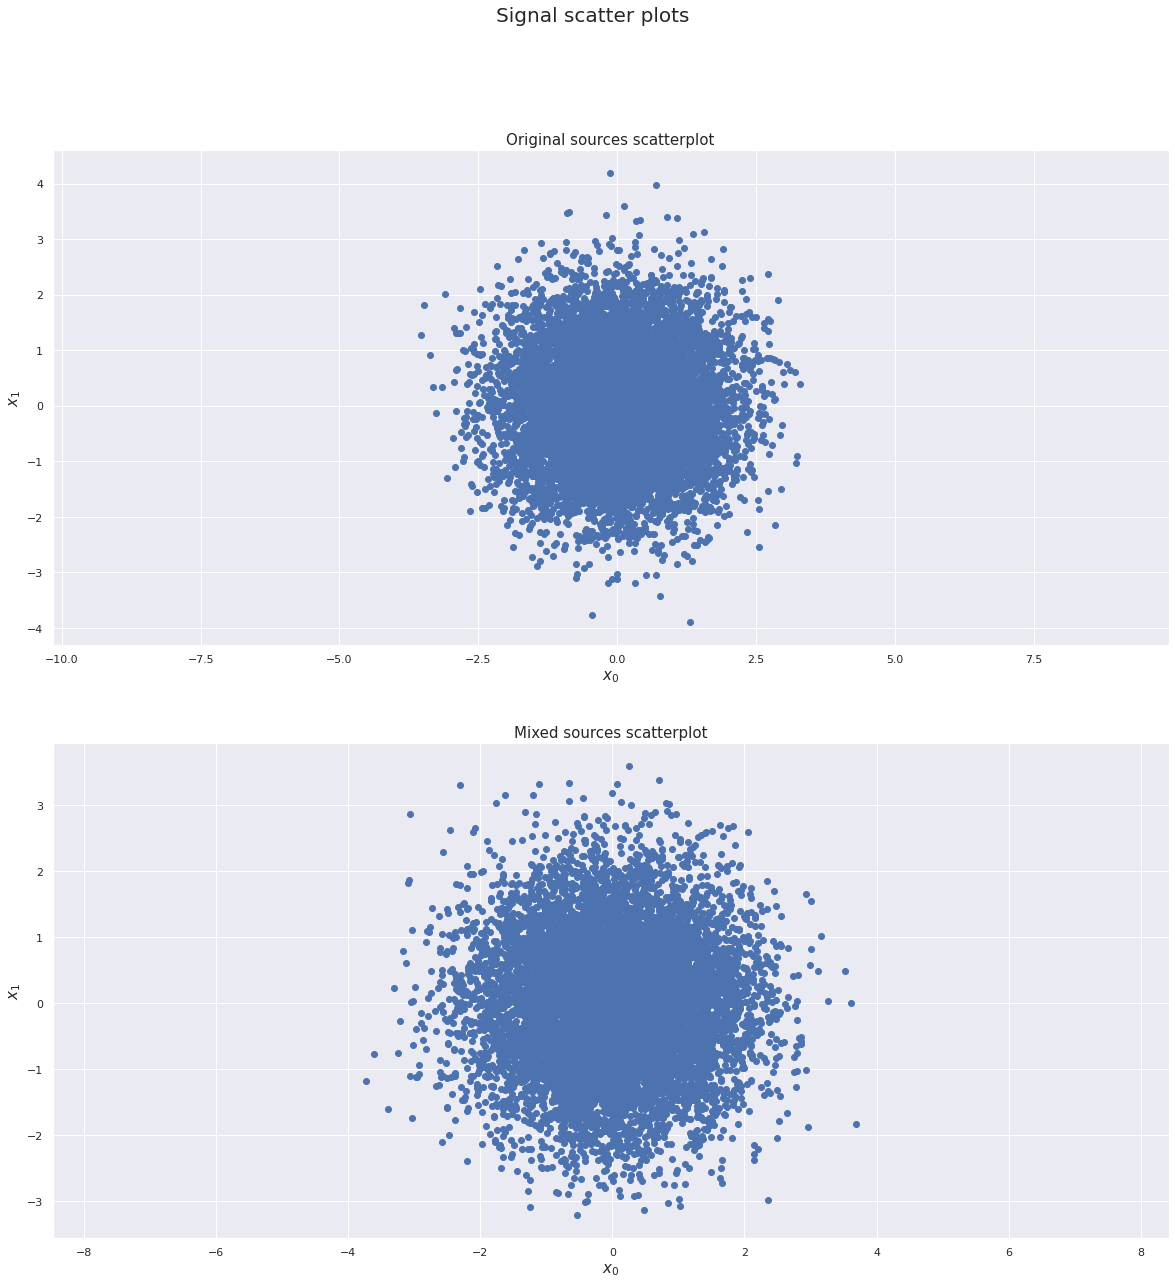

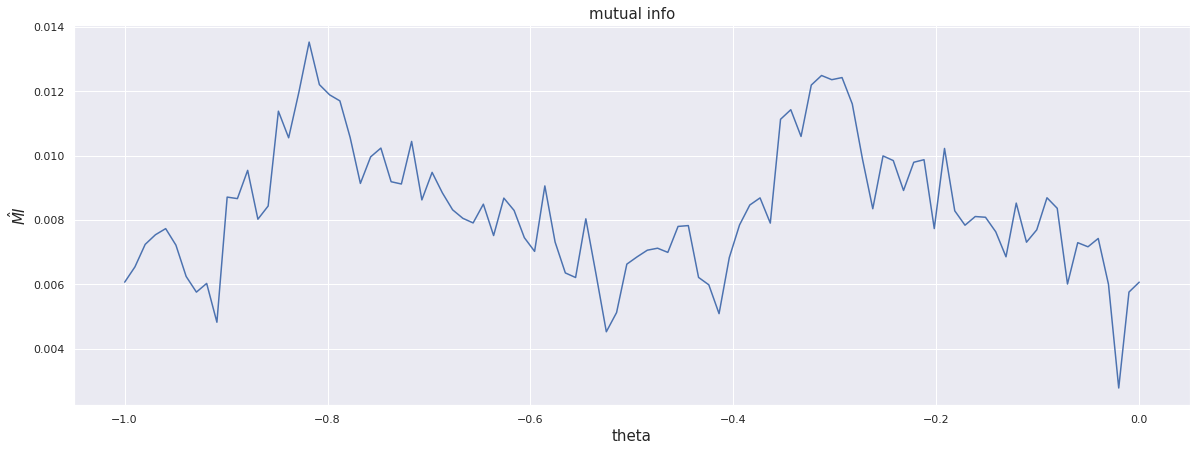

In [60]:
orthogonal_mixture_source_separation(
    N=10000,
    K=2,
    source_pdf_fn=lambda s: np.random.normal(0,1,s),
    mixing_theta=np.pi/4
)

# 2. Non-orthogonal mixture

In [17]:
def non_orthogonal_mixture_source_separation(
    N,
    K,
    H,
    source_pdf_fn,
    theta_res=500
):
    from sklearn.decomposition import PCA
    import pdb

    # Generate sources
    a=source_pdf_fn(
        s=(K,N)
    )

    # Get mixed signals
    x = H@a

    # Plot signals
    fig, (ax1, ax2) = plt.subplots(
        nrows=2, ncols=1,
        figsize=(20, 15)
    )
    for i in range(1,K+1):
        ax1.plot(
            range(N),
            a[i-1,:],
            label='a_{}'.format(i)
        )
        ax2.plot(
            range(N),
            x[i-1,:],
            label='x_{}'.format(i)
        )

    ax1.set_xlabel('n', fontsize=15)
    ax2.set_xlabel('n', fontsize=15)

    ax1.set_ylabel('a[n]', fontsize=15)
    ax2.set_ylabel('x[n]', fontsize=15)

    ax1.set_title('Independent sources', fontsize=15)
    ax2.set_title('Mixed signals', fontsize=15)

    ax1.legend(loc='upper right', fontsize=15)
    ax2.legend(loc='upper right', fontsize=15)
    
    # Whiten signals
    # Get eigenvalues and eigenvectors for correlation matrix of x via SVD
    U, Lamb, V = np.linalg.svd(
        np.corrcoef(x)
    )    

    # Get corresponding transformation matrix
    W_whitening = U.T@np.diag([
        1/np.sqrt(lamb) for lamb in Lamb
    ])@U
    
    
    # Perform whitening pre-processing
    x_whitened = W_whitening@x
    
    print('-'*100)
    print('Original signal correlation matrix:\n{}'.format(np.corrcoef(a)))
    print('-'*100)
    print('Mixed signal correlation matrix:\n{}'.format(np.corrcoef(x)))
    print('-'*100)
    print('Whitened signal correlation matrix:\n{}'.format(np.corrcoef(x_whitened)))
    print('-'*100)
    print('Mixed signal correlation matrix SVD Decomposition:\n')
    print('U: {}\n'.format(U))
    print('Lamb: {}\n'.format(np.diag(Lamb)))
    print('V: {}\n'.format(V))
    print('-'*100)
    
    fig2, (ax_scatter1, ax_scatter2, ax_scatter3) = plt.subplots(
        nrows=3,ncols=1,
        figsize=(20,30)
    )
    fig2.suptitle(
        'Signal scatter plots',
        fontsize=20
    )
    ax_scatter1.scatter(
        a[0,:],
        a[1,:]
    )
    ax_scatter1.axis('equal')
    ax_scatter1.set_xlabel('$x_{0}$', fontsize=15)
    ax_scatter1.set_ylabel('$x_{1}$', fontsize=15)
    ax_scatter1.set_title('Original sources scatterplot', fontsize=15)
    ax_scatter2.scatter(
        x[0,:],
        x[1,:]
    )
    ax_scatter2.axis('equal')
    ax_scatter2.set_xlabel('$x_{0}$', fontsize=15)
    ax_scatter2.set_ylabel('$x_{1}$', fontsize=15)
    ax_scatter2.set_title('Mixed sources scatterplot', fontsize=15)
    ax_scatter3.scatter(
        x_whitened[0,:],
        x_whitened[1,:]
    )
    ax_scatter3.axis('equal')
    ax_scatter3.set_xlabel('$x_{0}$', fontsize=15)
    ax_scatter3.set_ylabel('$x_{1}$', fontsize=15)
    ax_scatter3.set_title('Whitened sources scatterplot', fontsize=15)
    
    # Evaluated thetas
    eval_thetas = np.linspace(
        -np.pi, 0,
        theta_res
    )

    # Iterate to find optimal W
    logs=pd.DataFrame()
    for k, theta in enumerate(eval_thetas):
        W = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        y=W@x_whitened

        # Update logs matrix
        logs_update = pd.DataFrame(
            index=[0],
            data={
                'it': [k],
                'theta': [theta],
                'mutual_info': [MI(
                    y.T, y.T[:,0]
                )[1]]
            }
        )    
        logs = pd.concat(
            [
                logs,
                logs_update
            ],
            axis=0
        )
        
    # Plot mutual info
    fig = plt.figure(figsize=((20,7)))
    plt.plot(
        logs.theta/np.pi,
        logs.mutual_info
    )
    plt.title('mutual info', fontsize=15)
    plt.xlabel('theta', fontsize=15)
    plt.ylabel('$\hat{MI}$', fontsize=15)

### 2.1. Two Logistic pdf sources

----------------------------------------------------------------------------------------------------
Original signal correlation matrix:
[[1.00000000e+00 9.99517414e-04]
 [9.99517414e-04 1.00000000e+00]]
----------------------------------------------------------------------------------------------------
Mixed signal correlation matrix:
[[ 1.        -0.3177794]
 [-0.3177794  1.       ]]
----------------------------------------------------------------------------------------------------
Whitened signal correlation matrix:
[[1.         0.06689379]
 [0.06689379 1.        ]]
----------------------------------------------------------------------------------------------------
Mixed signal correlation matrix SVD Decomposition:

U: [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]

Lamb: [[1.3177794 0.       ]
 [0.        0.6822206]]

V: [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]

--------------------------------------------------------------------------------------------------

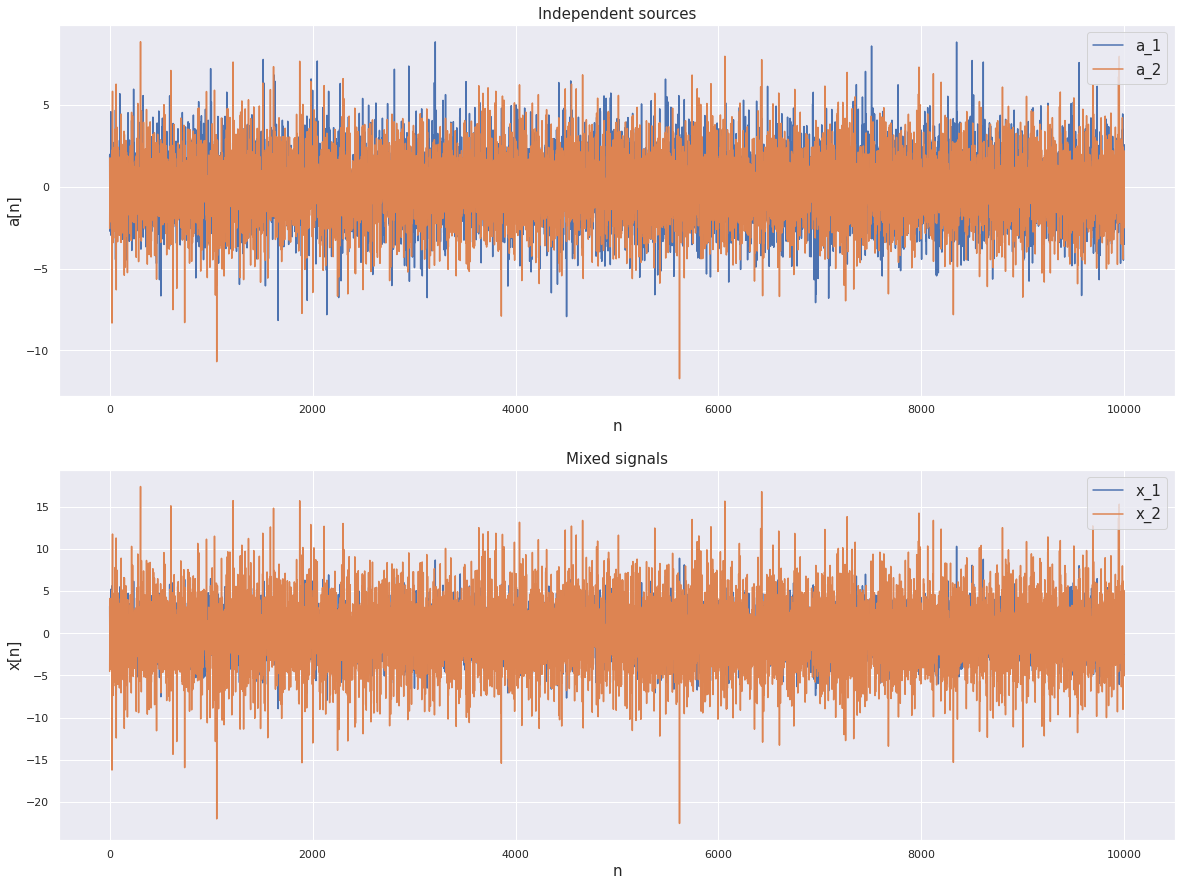

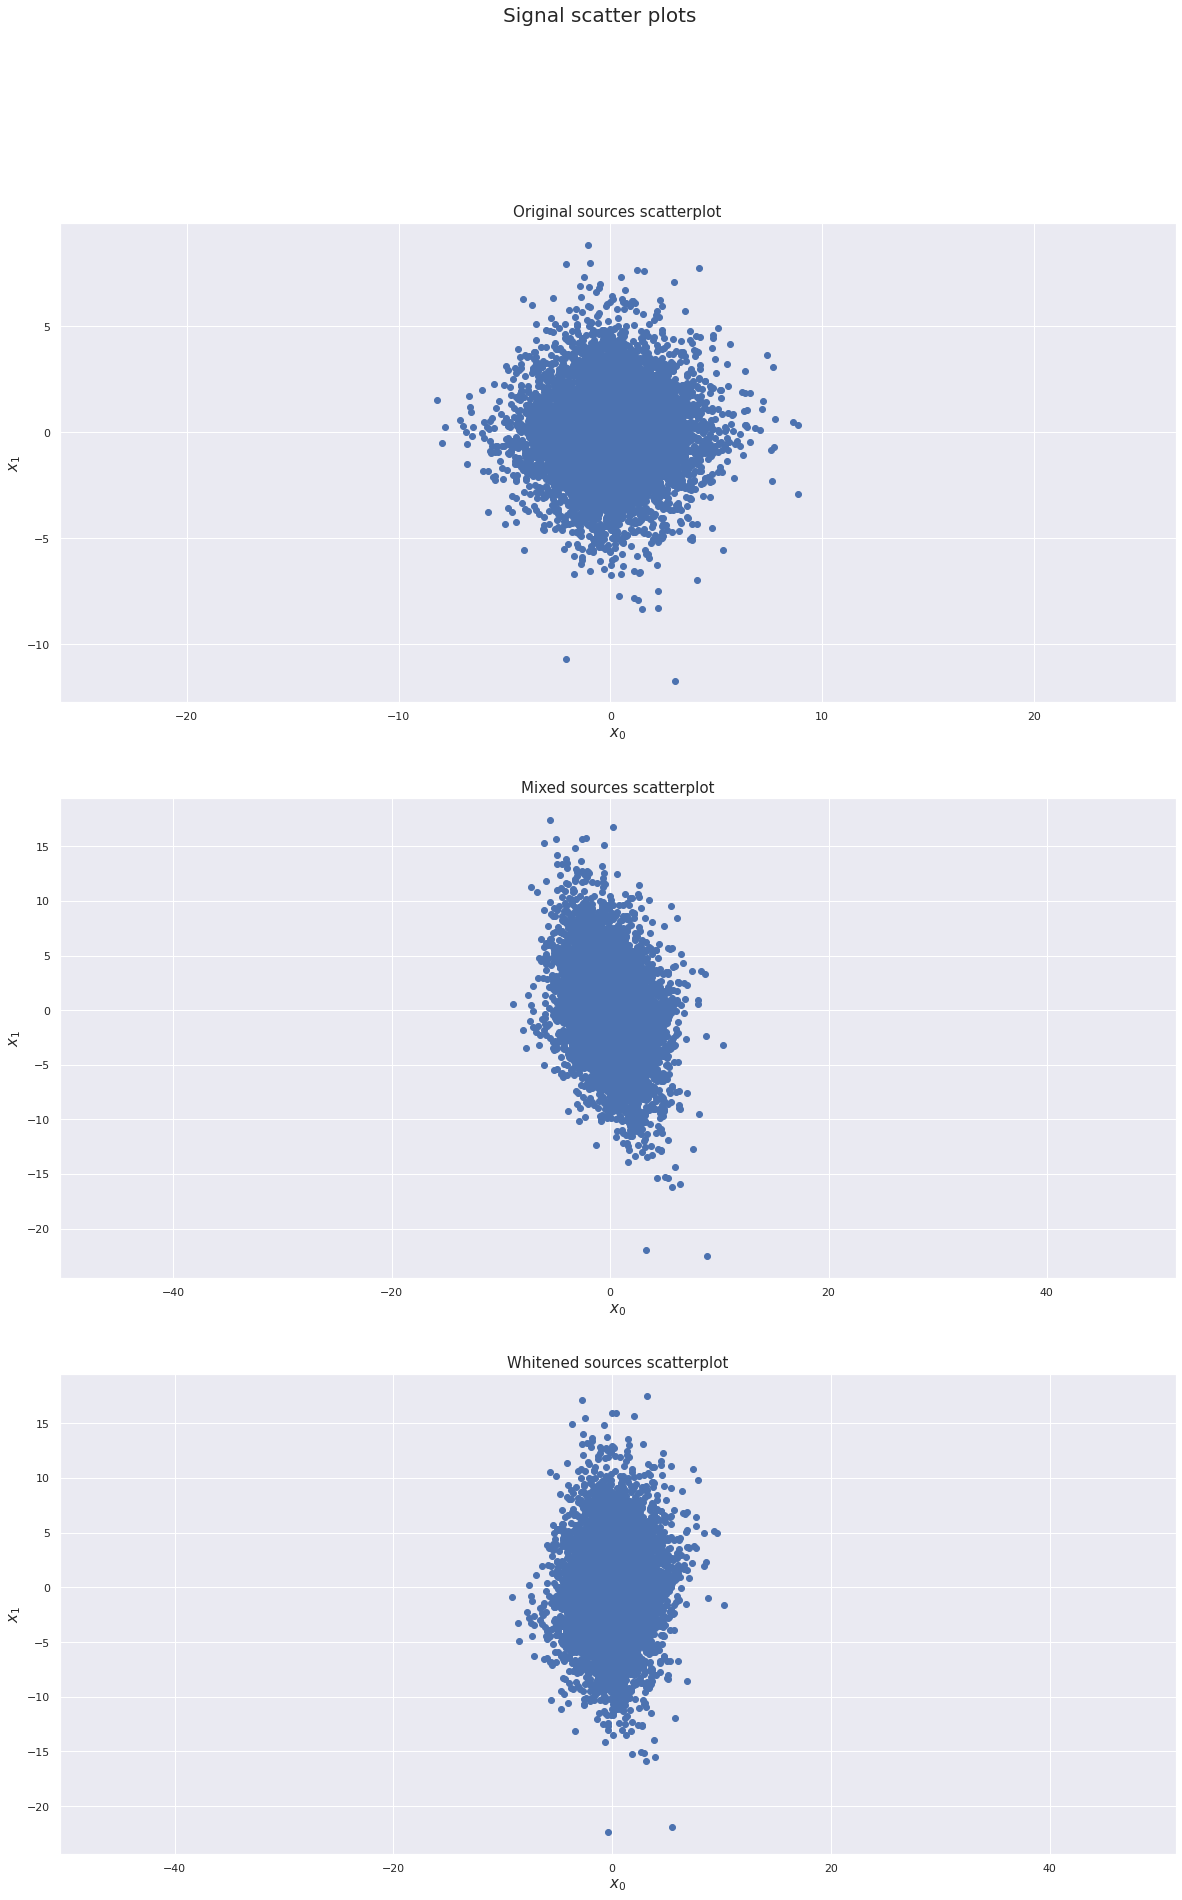

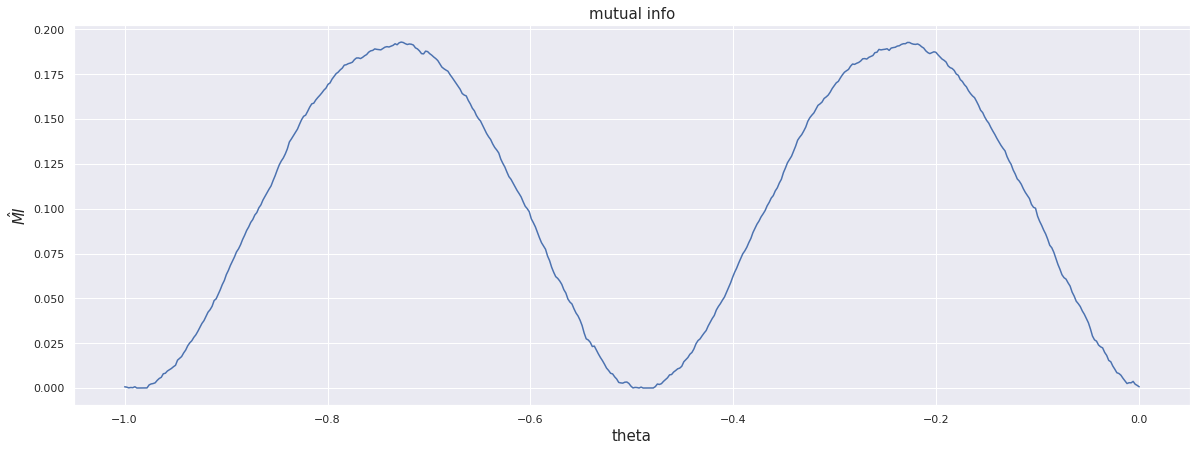

In [18]:
mixing_matrix = np.array([
    [1.0, -0.5],
    [0.3, 2.0]
])
non_orthogonal_mixture_source_separation(
    N=10000,
    K=2,
    H=mixing_matrix,
    source_pdf_fn=lambda s: np.random.logistic(0,1,s)
)

### 2.2. Two Uniform pdf sources

[[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
[1.30208789 0.69791211]
[[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
----------------------------------------------------------------------------------------------------
Original signal correlation matrix:
[[1.         0.00974006]
 [0.00974006 1.        ]]
----------------------------------------------------------------------------------------------------
Mixed signal correlation matrix:
[[ 1.         -0.30208789]
 [-0.30208789  1.        ]]
----------------------------------------------------------------------------------------------------
Whitened signal correlation matrix:
[[1.        0.0610372]
 [0.0610372 1.       ]]
----------------------------------------------------------------------------------------------------


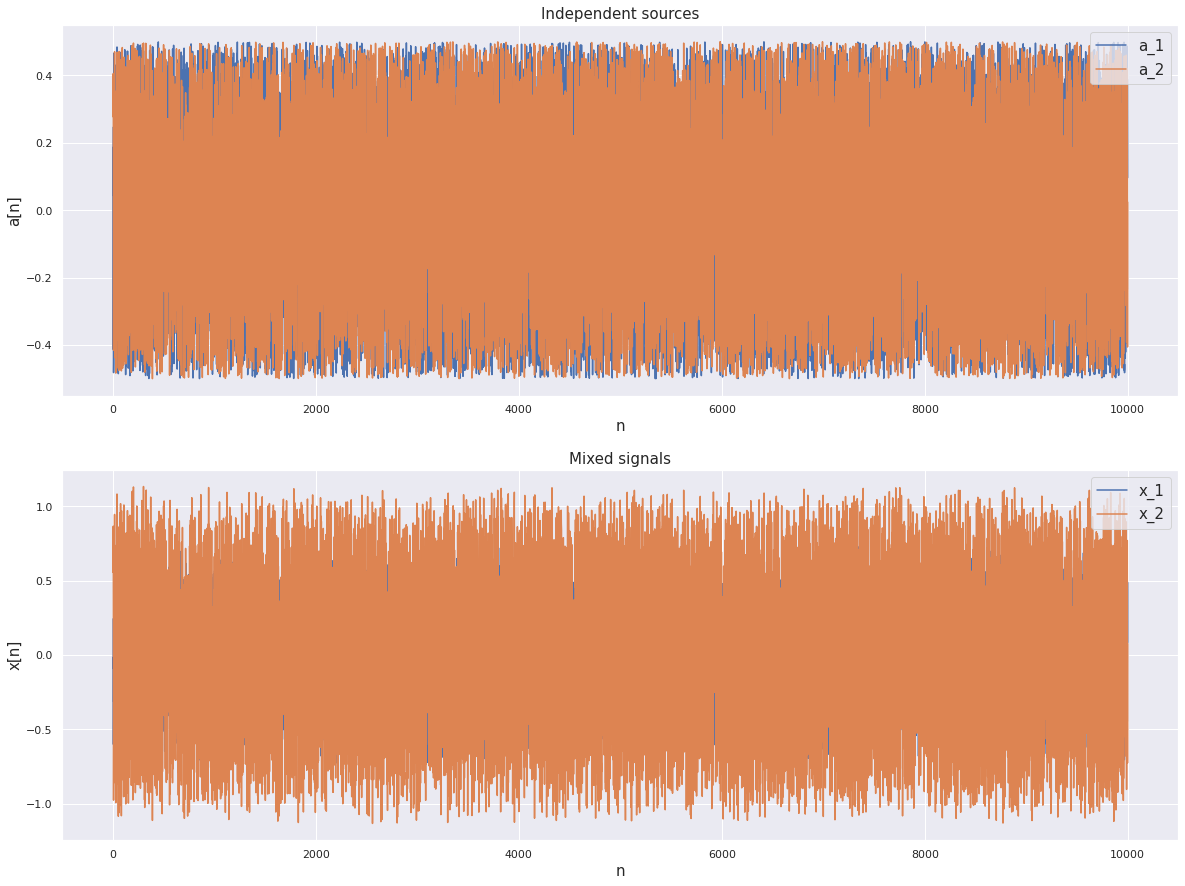

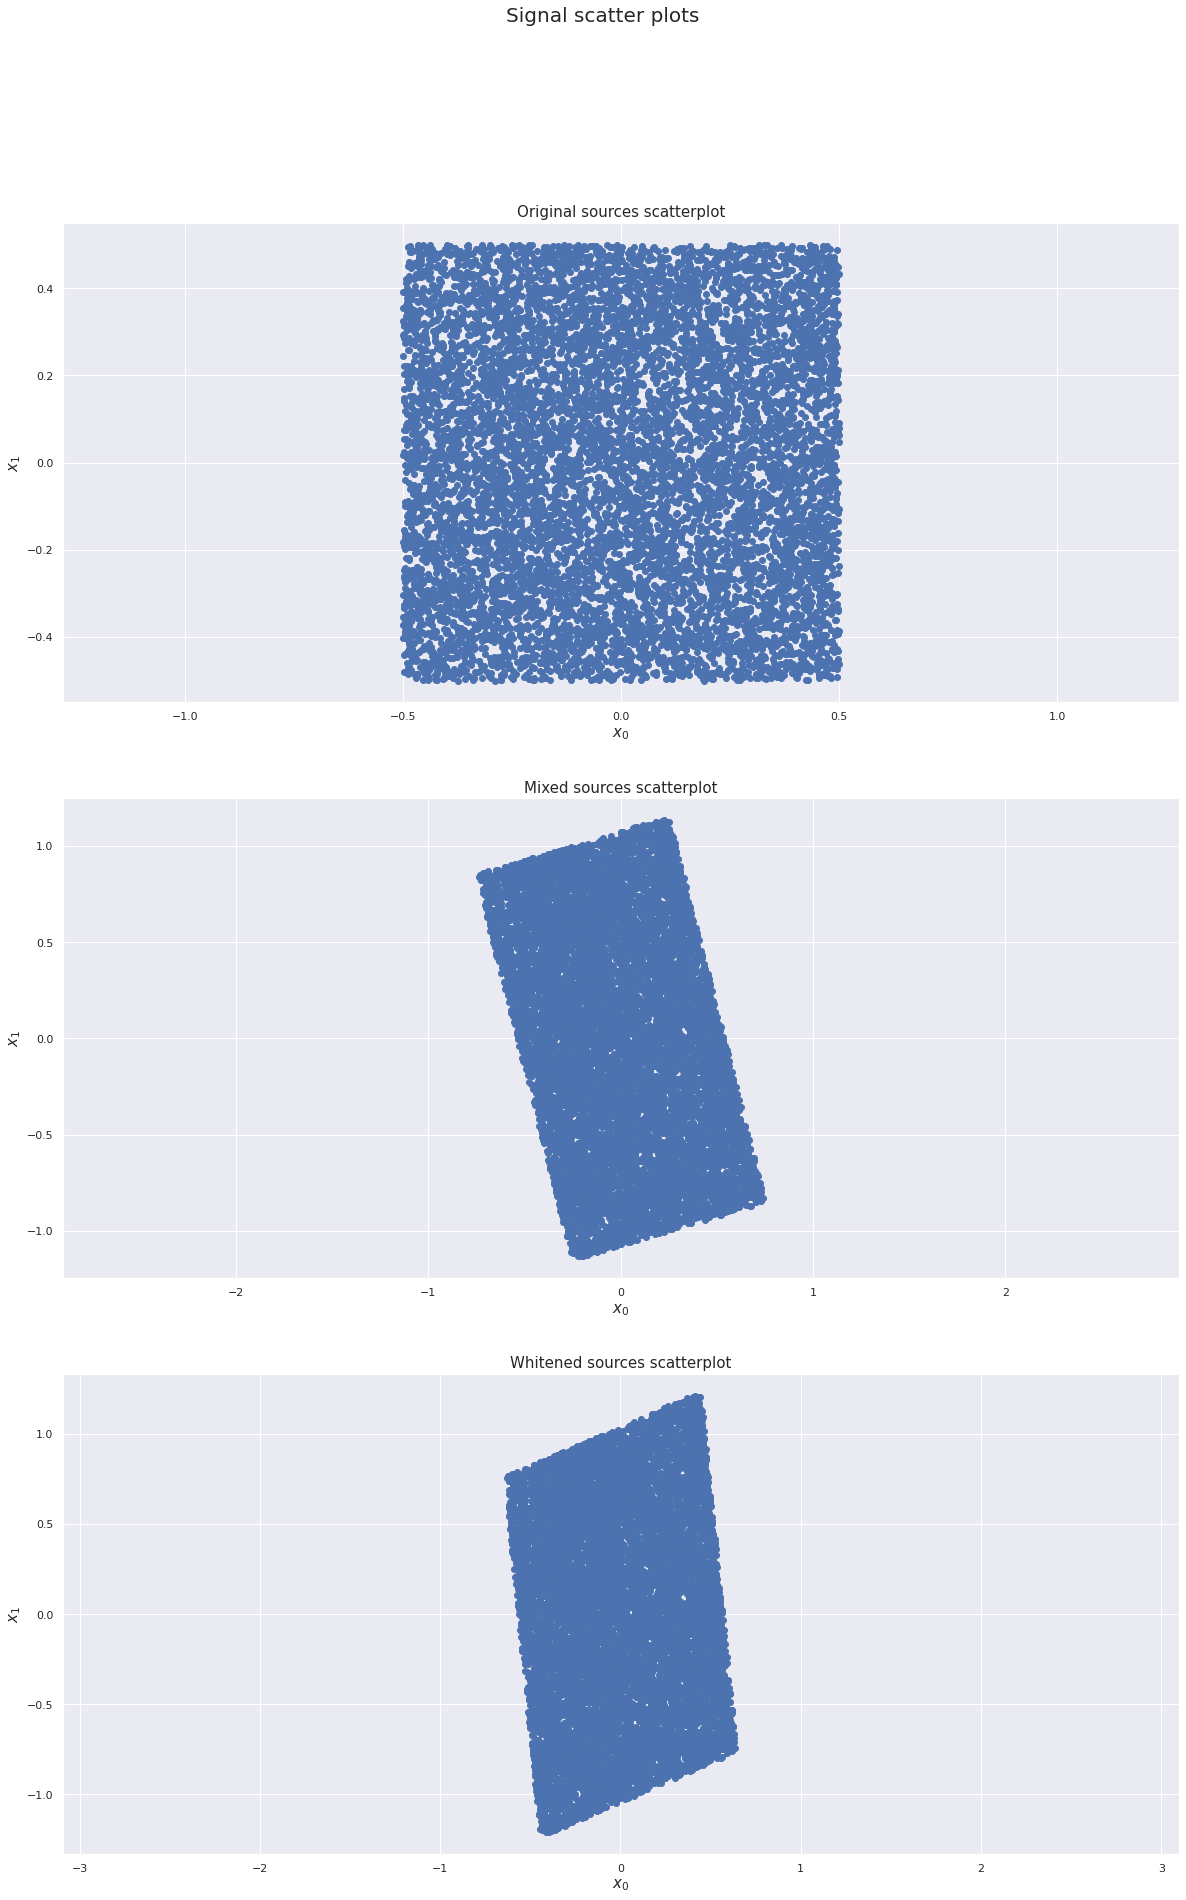

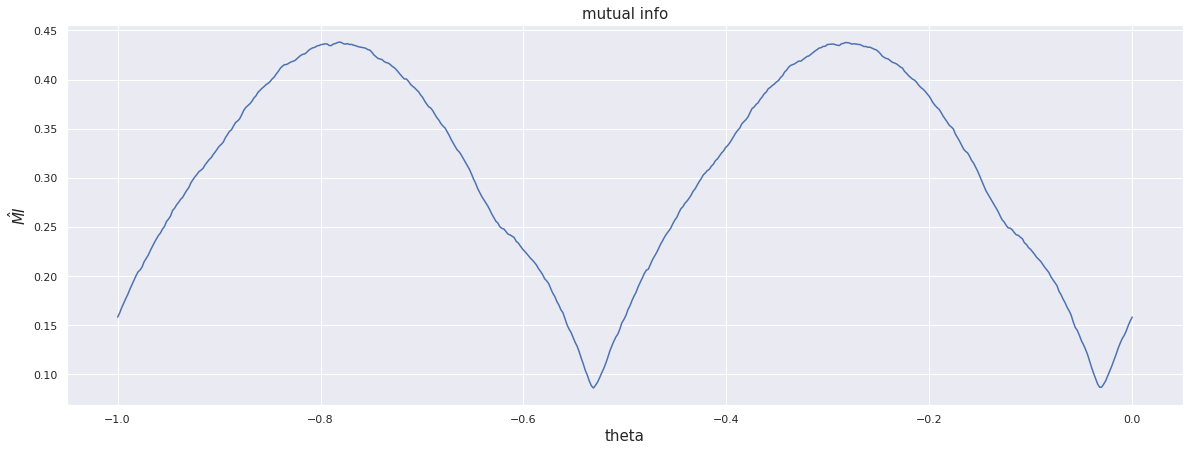

In [11]:
mixing_matrix = np.array([
    [1.0, -0.5],
    [0.3, 2.0]
])
non_orthogonal_mixture_source_separation(
    N=10000,
    K=2,
    H=mixing_matrix,
    source_pdf_fn=lambda s: np.random.uniform(-0.5,0.5,s)
)

### 2.3. Two Gaussian pdf sources

[[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
[1.31707845 0.68292155]
[[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
----------------------------------------------------------------------------------------------------
Original signal correlation matrix:
[[ 1.         -0.00213659]
 [-0.00213659  1.        ]]
----------------------------------------------------------------------------------------------------
Mixed signal correlation matrix:
[[ 1.         -0.31707845]
 [-0.31707845  1.        ]]
----------------------------------------------------------------------------------------------------
Whitened signal correlation matrix:
[[1.        0.0653248]
 [0.0653248 1.       ]]
----------------------------------------------------------------------------------------------------


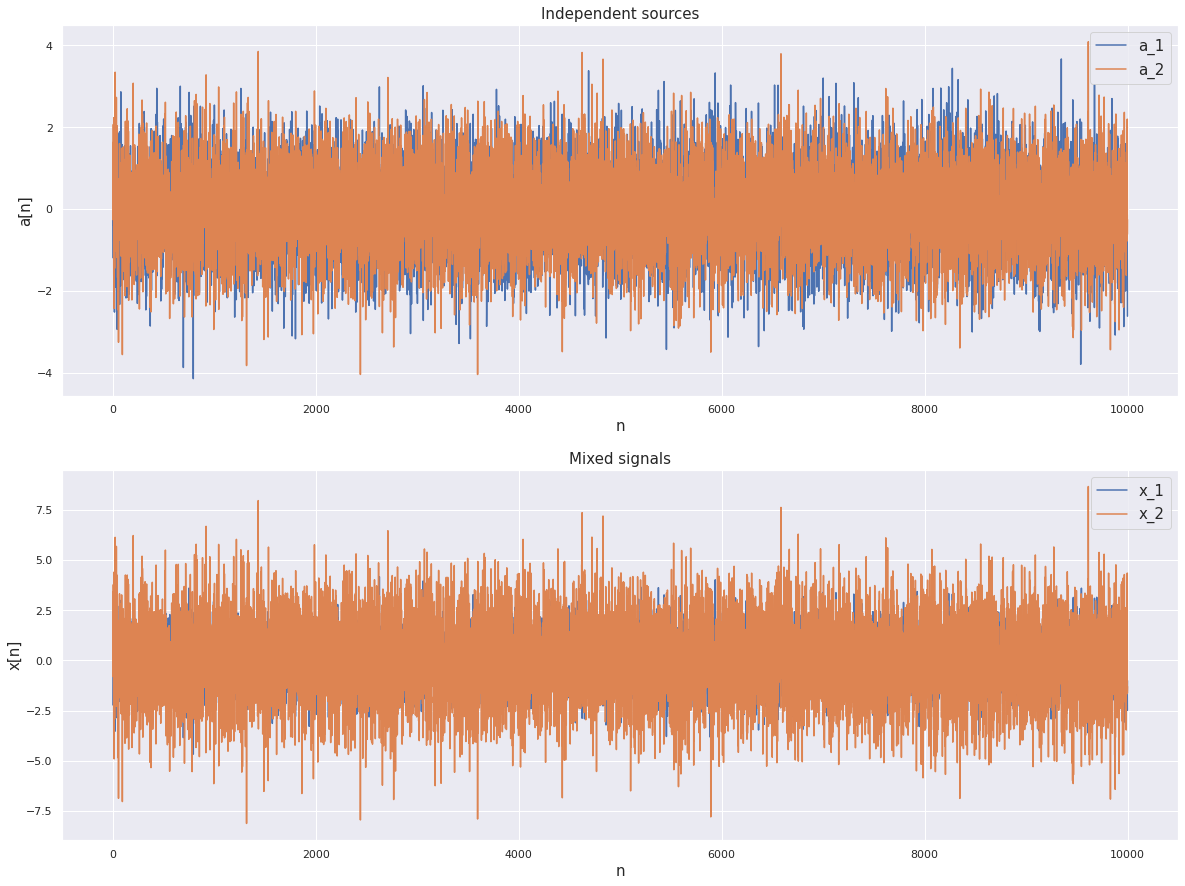

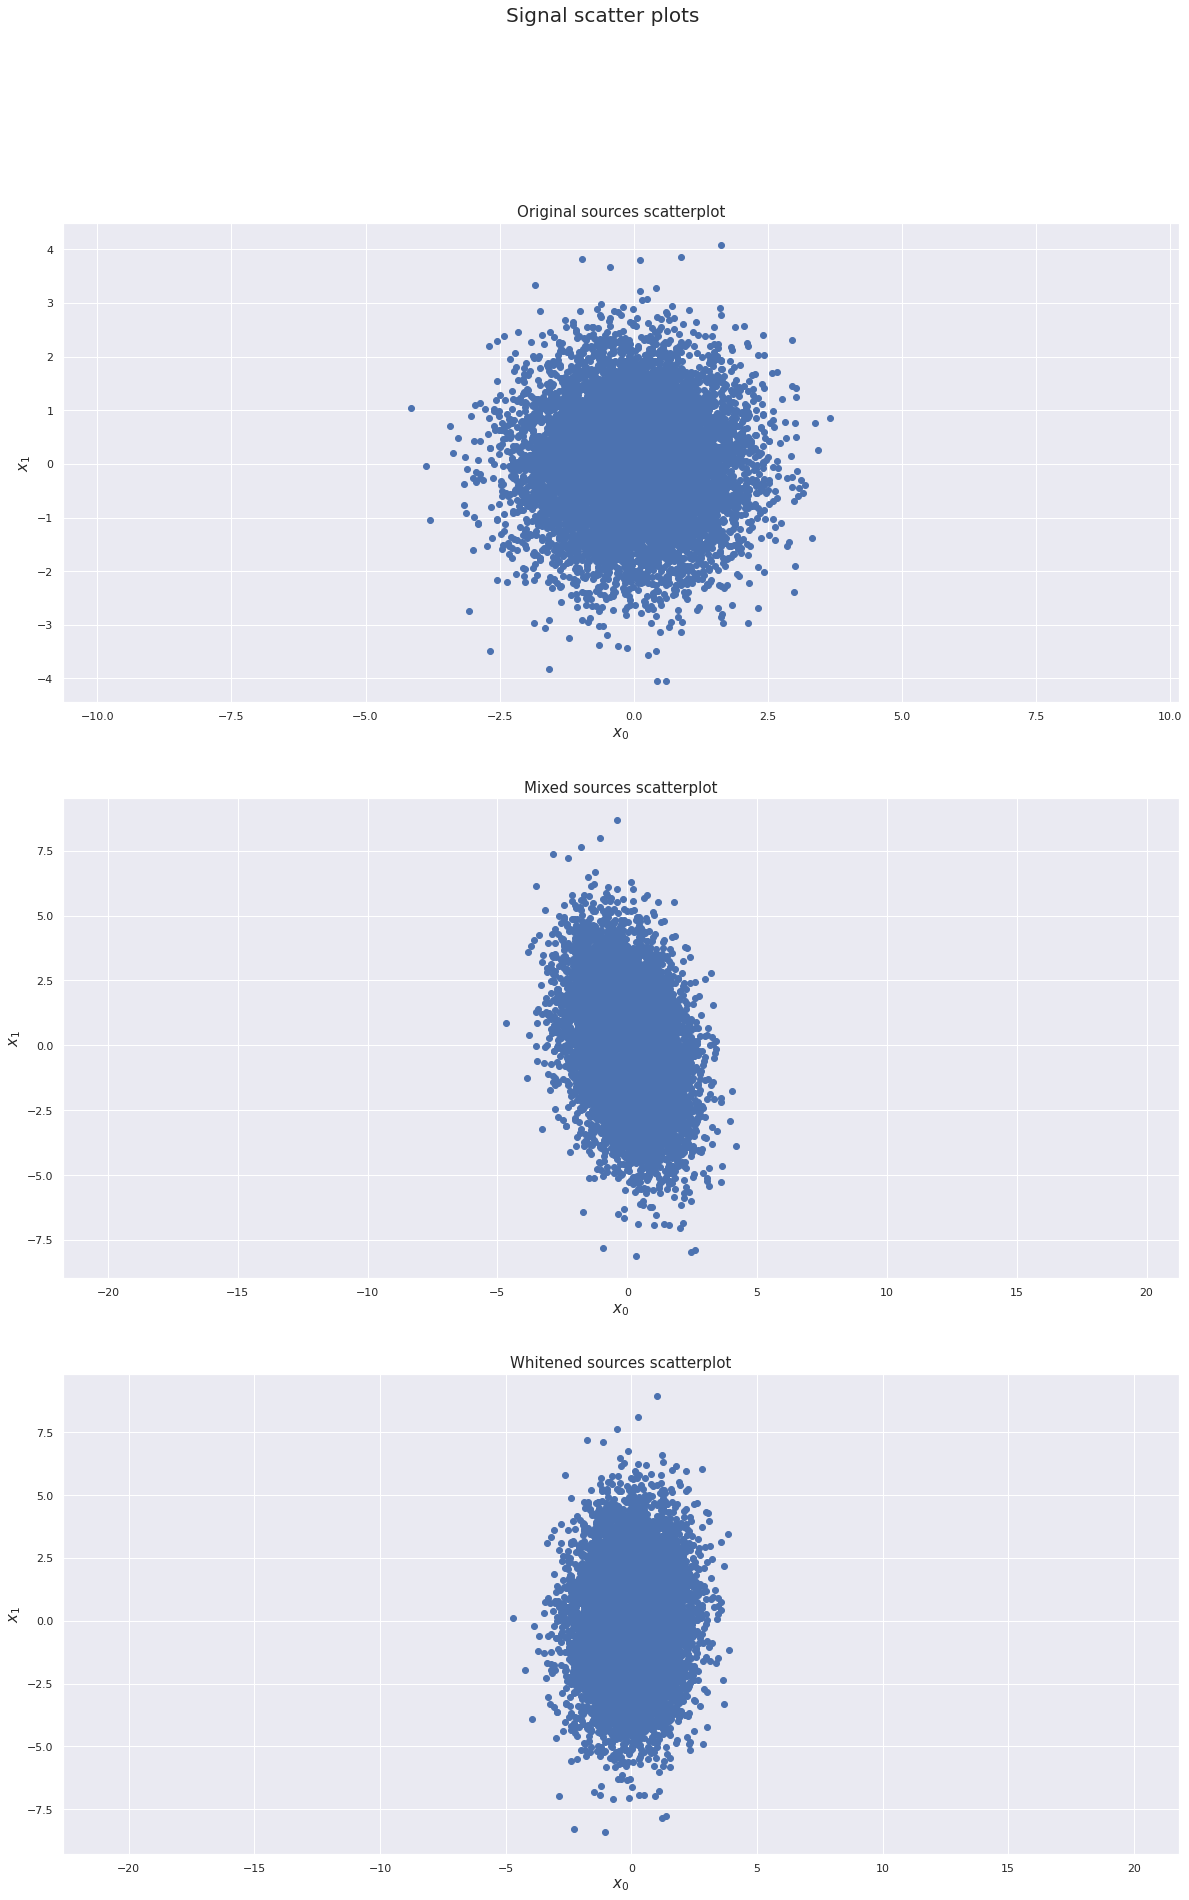

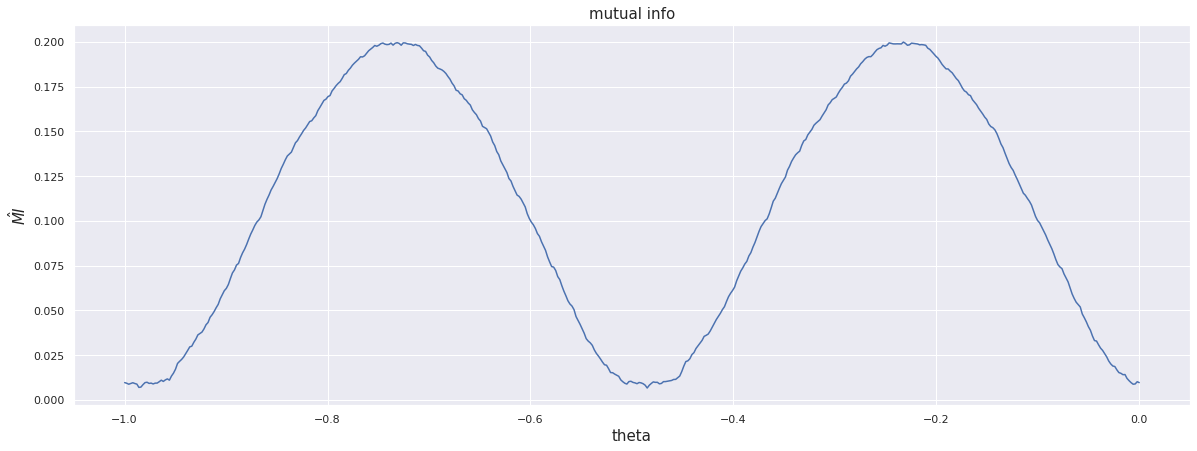

In [12]:
mixing_matrix = np.array([
    [1.0, -0.5],
    [0.3, 2.0]
])
non_orthogonal_mixture_source_separation(
    N=10000,
    K=2,
    H=mixing_matrix,
    source_pdf_fn=lambda s: np.random.normal(0,1,s)
)